In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import ipywidgets as widgets
from ipywidgets import interactive, VBox, HBox
from IPython.display import display

# =============================================================================
# PHẦN 1: CÁC HÀM GIẢ LẬP CỐT LÕI (v7.0 - 16x16)
# =============================================================================

def tao_dom_gaussian(ma_tran, vi_tri, cuong_do, do_rong_y, do_rong_x):
    """Vẽ một "đốm sáng" Gaussian 2D (hình elip) lên ma trận."""
    if cuong_do <= 0: return ma_tran 
    k_thuoc_y, k_thuoc_x = ma_tran.shape
    y, x = vi_tri
    
    ys, xs = np.ogrid[:k_thuoc_y, :k_thuoc_x]
    
    # Tính toán cho hiệu ứng "quấn quanh" (wrap-around) trên trục X
    dx1 = xs - x
    dx2 = xs - (x + k_thuoc_x) 
    dx3 = xs - (x - k_thuoc_x) 
    dx = np.minimum(np.abs(dx1), np.minimum(np.abs(dx2), np.abs(dx3)))

    # Tránh chia cho 0
    do_rong_y_sq = max(do_rong_y**2, 1e-6)
    do_rong_x_sq = max(do_rong_x**2, 1e-6)

    khoang_cach_binh_phuong = ( (ys - y)**2 / (do_rong_y_sq) ) + ( dx**2 / (do_rong_x_sq) )
    
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / 2)
    ma_tran += dom_sang
    return ma_tran

def gia_lap_ban_do_tinh_v7(goc_MCP, goc_PIP, goc_DIP, k_thuoc=16): # Mặc định là 16
    """
    Giả lập bản đồ TĨNH 16x16 - PHIÊN BẢN v7.1 (ĐÃ TỐI ƯU)
    Logic "DẤU ẤN 360 ĐỘ" - Sửa lỗi "Liên kết Gân"
    """
    ban_do = np.zeros((k_thuoc, k_thuoc))
    
    rad_MCP = np.deg2rad(goc_MCP)
    rad_PIP = np.deg2rad(goc_PIP)
    rad_DIP_chu_dong = np.deg2rad(goc_DIP) 

    # --- QUY LUẬT "LIÊN KẾT GÂN" (ĐÃ TỐI ƯU) ---
    stiffness_factor = 0.0
    if goc_MCP > 70: stiffness_factor += (goc_MCP - 70) / 20.0
    if goc_PIP > 60: stiffness_factor += (goc_PIP - 60) / 30.0
    stiffness_factor = np.clip(stiffness_factor, 0, 1.0) 
    influence_passive = stiffness_factor * 0.7 
    influence_active = 1.0 - influence_passive 
    rad_DIP_thu_dong = rad_PIP * 0.5 
    rad_DIP_hieu_luc = (rad_DIP_chu_dong * influence_active) + (rad_DIP_thu_dong * influence_passive)
    # --- KẾT THÚC QUY LUẬT MỚI ---
    
    
    # --- 1. ĐỊNH NGHĨA TỌA ĐỘ (ĐÃ SCALE x2 CHO 16x16) ---
    scale = k_thuoc / 8.0 # Tỷ lệ = 16/8 = 2.0
    
    # Tọa độ Y (Dọc ngón tay)
    y_MCP_joint = 7.0 * scale
    y_Pad1 = 6.0 * scale
    y_PIP_joint = 5.0 * scale
    y_Pad2 = 4.0 * scale
    y_DIP_joint = 3.0 * scale
    y_Pad3 = 2.0 * scale
    y_Tip = 1.0 * scale
    
    # Tọa độ X (Chu vi ngón tay)
    x_back = 0.0 # Mu bàn tay (vẫn ở rìa)
    x_front = 4.0 * scale # Lòng bàn tay (ở giữa ma trận 16x16)

    # --- 2. TÍNH CƯỜNG ĐỘ (Giữ nguyên logic) ---
    cuong_do_MCP_joint = 1.0 * np.sin(rad_MCP)
    cuong_do_PIP_joint = 1.0 * np.sin(rad_PIP)
    cuong_do_DIP_joint = 1.0 * np.sin(rad_DIP_hieu_luc)
    
    cuong_do_Pad1 = 0.2 + 0.8 * np.sin(rad_MCP)
    cuong_do_Pad2 = 0.2 + 0.8 * np.sin(rad_PIP)
    cuong_do_Pad3 = 0.2 + 0.8 * np.sin(rad_DIP_hieu_luc)
    cuong_do_Tip  = 0.3 + 0.7 * np.sin((rad_MCP + rad_PIP + rad_DIP_hieu_luc) / 3)

    # --- 3. VẼ CÁC "VÀNH ĐAI" ÁP SUẤT (ĐÃ SCALE x2) ---
    tao_dom_gaussian(ban_do, (y_MCP_joint, x_back), cuong_do_MCP_joint, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    tao_dom_gaussian(ban_do, (y_PIP_joint, x_back), cuong_do_PIP_joint, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    tao_dom_gaussian(ban_do, (y_DIP_joint, x_back), cuong_do_DIP_joint, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    
    tao_dom_gaussian(ban_do, (y_Pad1, x_front), cuong_do_Pad1, do_rong_y=1.0*scale, do_rong_x=2.5*scale)
    tao_dom_gaussian(ban_do, (y_Pad2, x_front), cuong_do_Pad2, do_rong_y=1.0*scale, do_rong_x=2.5*scale)
    tao_dom_gaussian(ban_do, (y_Pad3, x_front), cuong_do_Pad3, do_rong_y=1.0*scale, do_rong_x=2.5*scale)
    tao_dom_gaussian(ban_do, (y_Tip, x_front), cuong_do_Tip, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    
    # --- 4. THÊM NHIỄU VÀ CHUẨN HÓA ---
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.1
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
        
    # Trả về bản đồ và CÁC GÓC THỰC TẾ (để dùng cho huấn luyện)
    goc_DIP_hieu_luc_thuc_te = np.rad2deg(rad_DIP_hieu_luc)
    
    # Trả về cả 3 giá trị để nhất quán
    return ban_do, goc_MCP, goc_PIP, goc_DIP_hieu_luc_thuc_te

# --- HÀM MỚI: tao_dom_gaussian_khong_wrap ---
def tao_dom_gaussian_khong_wrap(ma_tran, vi_tri, cuong_do, do_rong_y, do_rong_x):
    """Vẽ một "đốm sáng" Gaussian 2D (hình elip) lên ma trận mà KHÔNG có hiệu ứng quấn quanh."""
    if cuong_do <= 0: return ma_tran 
    k_thuoc_y, k_thuoc_x = ma_tran.shape
    y, x = vi_tri
    
    ys, xs = np.ogrid[:k_thuoc_y, :k_thuoc_x]
    
    dx = xs - x # Không "wrap-around"

    # Tránh chia cho 0
    do_rong_y_sq = max(do_rong_y**2, 1e-6)
    do_rong_x_sq = max(do_rong_x**2, 1e-6)

    khoang_cach_binh_phuong = ( (ys - y)**2 / (do_rong_y_sq) ) + ( dx**2 / (do_rong_x_sq) )
    
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / 2)
    ma_tran += dom_sang
    return ma_tran

# --- Cập nhật hàm gia_lap_ban_do_dong (ĐÃ SCALE x2) ---
def gia_lap_ban_do_dong(vi_tri_tham_do, do_cung, k_thuoc=16): # Mặc định là 16
    """Giả lập bản đồ ĐỘNG 16x16 khi gantry thăm dò từ trên xuống."""
    ban_do = np.zeros((k_thuoc, k_thuoc))
    cuong_do = do_cung / 10.0
    
    scale = k_thuoc / 8.0 # Tỷ lệ = 2.0
    
    # Scale độ rộng của đốm phản lực
    do_rong_y_dong = (0.8 - (do_cung / 10.0) * 0.4) * scale
    do_rong_x_dong = (0.8 - (do_cung / 10.0) * 0.4) * scale

    tao_dom_gaussian_khong_wrap(ban_do, vi_tri_tham_do, cuong_do, do_rong_y_dong, do_rong_x_dong)

    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.05
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
    return ban_do

# =============================================================================
# === BẮT ĐẦU PHẦN CODE MỚI THÊM VÀO ===
# =============================================================================

def gia_lap_luc_phan_hoi(goc_MCP, goc_PIP, goc_DIP, k_cung=0.1, nhieu=0.05):
    """
    Giả lập lực phản hồi (co cứng) tại mỗi khớp.
    Hàm này dùng để tạo đầu vào thứ 2 cho "Mô hình Hợp nhất".
    
    k_cung: Hệ số co cứng (ví dụ: 0.1 N/độ). Bạn có thể điều chỉnh giá trị 
            này hoặc thay thế bằng một logic phức tạp hơn.
    nhieu: Mức độ nhiễu ngẫu nhiên của cảm biến lực.
    """
    # Mô hình vật lý đơn giản: Lực = Hệ số co cứng * Góc
    # (Bạn có thể làm nó phức tạp hơn, ví dụ: phi tuyến tính)
    luc_MCP = (goc_MCP * k_cung) + np.random.uniform(-nhieu, nhieu)
    luc_PIP = (goc_PIP * k_cung) + np.random.uniform(-nhieu, nhieu)
    luc_DIP = (goc_DIP * k_cung) + np.random.uniform(-nhieu, nhieu)
    
    # Đảm bảo lực không bao giờ âm
    return np.array([
        max(0, luc_MCP), 
        max(0, luc_PIP), 
        max(0, luc_DIP)
    ])

# =============================================================================
# === KẾT THÚC PHẦN CODE MỚI THÊM VÀO ===
# =============================================================================


# --- HÀM ve_khung_xuong_3d (Không cần thay đổi) ---
def ve_khung_xuong_3d(ax, goc_MCP, goc_PIP, goc_DIP, mau='b', label=''):
    L1, L2, L3 = 3, 2, 1
    rad_MCP = np.deg2rad(goc_MCP); rad_PIP = np.deg2rad(goc_PIP); rad_DIP = np.deg2rad(goc_DIP)
    J0 = [0, 0, 0]
    J1 = [0, L1 * np.cos(rad_MCP), L1 * np.sin(rad_MCP)]
    goc_tich_luy_PIP = rad_MCP + rad_PIP
    J2 = [0, J1[1] + L2 * np.cos(goc_tich_luy_PIP), J1[2] + L2 * np.sin(goc_tich_luy_PIP)]
    goc_tich_luy_DIP = goc_tich_luy_PIP + rad_DIP
    Tip = [0, J2[1] + L3 * np.cos(goc_tich_luy_DIP), J2[2] + L3 * np.sin(goc_tich_luy_DIP)]
    points = np.array([J0, J1, J2, Tip])
    ax.plot(points[:, 0], points[:, 1], points[:, 2], marker='o', color=mau, label=label)
    ax.set_xlabel('X'); ax.set_ylabel('Y'); ax.set_zlabel('Z')
    ax.set_title("Mô hình 3D"); ax.set_xlim([-1, 1]); ax.set_ylim([0, 6]); ax.set_zlim([0, 6])

# =============================================================================
# PHẦN 2: TẠO GIAO DIỆN TƯƠNG TÁC (ĐÃ CẬP NHẬT CHO 16x16)
# =============================================================================

def cap_nhat_giao_dien(goc_MCP, goc_PIP, goc_DIP, do_cung):
    fig, (ax1, ax2, ax3_placeholder) = plt.subplots(1, 3, figsize=(18, 6))
    
    K_THUOC_HIENTAI = 16 # Đặt kích thước ma trận là 16
    scale = K_THUOC_HIENTAI / 8.0 # = 2.0
    
    # --- Ô 1: BẢN ĐỒ TĨNH (16x16) ---
    # Lấy bản đồ (và các góc hiệu lực thực tế, mặc dù không dùng trong hiển thị này)
    ban_do_tinh, _, _, _ = gia_lap_ban_do_tinh_v7(goc_MCP, goc_PIP, goc_DIP, k_thuoc=K_THUOC_HIENTAI)
    
    im1 = ax1.imshow(ban_do_tinh, cmap='viridis', vmin=0, vmax=1, aspect='auto')
    ax1.set_title("Bản đồ Tĩnh 360° 16x16")
    ax1.set_xlabel(f"Chu vi (0: Mu, {4*scale:.0f}: Lòng)") # 0: Mu, 8: Lòng
    ax1.set_ylabel(f"Dọc ngón tay ({7*scale:.0f}: Gốc, 0: Ngọn)") # 14: Gốc
    ax1.set_xticks(np.arange(K_THUOC_HIENTAI))
    ax1.set_yticks(np.arange(K_THUOC_HIENTAI))
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)

    # --- Ô 2: BẢN ĐỒ ĐỘNG (16x16) ---
    # Giả sử thăm dò khớp PIP (y=5*scale) ở mu bàn tay (x=0)
    vi_tri_tham_do = (5.0 * scale, 0) # (10, 0)
    ban_do_dong = gia_lap_ban_do_dong(vi_tri_tham_do, do_cung, k_thuoc=K_THUOC_HIENTAI)
    im2 = ax2.imshow(ban_do_dong, cmap='inferno', vmin=0, vmax=1, aspect='auto')
    ax2.set_title(f"Bản đồ Động (Phản lực {do_cung:.1f}/10)")
    ax2.set_xlabel("Chu vi ngón tay"); ax2.set_ylabel("Dọc ngón tay")
    ax2.set_xticks(np.arange(K_THUOC_HIENTAI))
    ax2.set_yticks(np.arange(K_THUOC_HIENTAI))
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # --- Ô 3: MÔ HÌNH 3D ---
    fig.delaxes(ax3_placeholder)
    ax3 = fig.add_subplot(1, 3, 3, projection='3d')
    ve_khung_xuong_3d(ax3, 0, 0, 0, mau='g', label='Duỗi thẳng')
    ve_khung_xuong_3d(ax3, goc_MCP, goc_PIP, goc_DIP, mau='r', label=f'Co (Độ cứng {do_cung:.1f})')
    ax3.legend()
    
    plt.tight_layout()
    plt.show()

# --- TẠO THANH TRƯỢT VÀ HIỂN THỊ ---
slider_MCP = widgets.IntSlider(value=0, min=0, max=90, step=1, description='Góc MCP:')
slider_PIP = widgets.IntSlider(value=0, min=0, max=90, step=1, description='Góc PIP:')
slider_DIP = widgets.IntSlider(value=0, min=0, max=90, step=1, description='Góc DIP:')
slider_do_cung = widgets.FloatSlider(value=5.0, min=0.0, max=10.0, step=0.1, 
                                     description='Độ cứng:', readout_format='.1f')

interactive_output = interactive(cap_nhat_giao_dien, goc_MCP=slider_MCP, goc_PIP=slider_PIP, 
                                 goc_DIP=slider_DIP, do_cung=slider_do_cung) 
ui_controls = VBox([HBox([slider_MCP, slider_PIP]), HBox([slider_DIP, slider_do_cung])])
output_charts = interactive_output.children[-1]
display(VBox([ui_controls, output_charts]))

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint # <-- THÊM DÒNG NÀY
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import time

print("--- Cell 1: Đã import các thư viện (đã bao gồm Callbacks) ---")
print(f"TensorFlow Version: {tf.__version__}")

--- Cell 1: Đã import các thư viện (đã bao gồm Callbacks) ---
TensorFlow Version: 2.20.0


In [13]:
# CELL 2: CÁC HÀM GIẢ LẬP CỐT LÕI (BẢN ĐỒ)
# =============================================================================

# --- HÀM GAUSSIAN CHO BẢN ĐỒ TĨNH (CÓ WRAP-AROUND) ---
def tao_dom_gaussian(ma_tran, vi_tri, cuong_do, do_rong_y, do_rong_x):
    if cuong_do <= 0: return ma_tran 
    k_thuoc_y, k_thuoc_x = ma_tran.shape
    y, x = vi_tri
    ys, xs = np.ogrid[:k_thuoc_y, :k_thuoc_x]
    dx1 = xs - x; dx2 = xs - (x + k_thuoc_x); dx3 = xs - (x - k_thuoc_x) 
    dx = np.minimum(np.abs(dx1), np.minimum(np.abs(dx2), np.abs(dx3)))
    do_rong_y_sq = max(do_rong_y**2, 1e-6)
    do_rong_x_sq = max(do_rong_x**2, 1e-6)
    khoang_cach_binh_phuong = ( (ys - y)**2 / (do_rong_y_sq) ) + ( dx**2 / (do_rong_x_sq) )
    dom_sang = cuong_do * np.exp(-khoang_cach_binh_phuong / 2)
    ma_tran += dom_sang
    return ma_tran

# --- HÀM GIẢ LẬP BẢN ĐỒ TĨNH v7.1 (ĐÃ SCALE 16x16) ---
def gia_lap_ban_do_tinh_v7(goc_MCP, goc_PIP, goc_DIP, k_thuoc=16): # Mặc định là 16
    ban_do = np.zeros((k_thuoc, k_thuoc))
    rad_MCP = np.deg2rad(goc_MCP)
    rad_PIP = np.deg2rad(goc_PIP)
    rad_DIP_chu_dong = np.deg2rad(goc_DIP) 

    # --- QUY LUẬT "LIÊN KẾT GÂN" (ĐÃ TỐI ƯU) ---
    stiffness_factor = 0.0
    if goc_MCP > 70: stiffness_factor += (goc_MCP - 70) / 20.0
    if goc_PIP > 60: stiffness_factor += (goc_PIP - 60) / 30.0
    stiffness_factor = np.clip(stiffness_factor, 0, 1.0) 
    influence_passive = stiffness_factor * 0.7 
    influence_active = 1.0 - influence_passive 
    rad_DIP_thu_dong = rad_PIP * 0.5 
    rad_DIP_hieu_luc = (rad_DIP_chu_dong * influence_active) + (rad_DIP_thu_dong * influence_passive)
    # --- KẾT THÚC QUY LUẬT MỚI ---
    
    # --- 1. ĐỊNH NGHĨA TỌA ĐỘ (ĐÃ SCALE) ---
    scale = k_thuoc / 8.0 # Tỷ lệ = 16/8 = 2.0
    y_MCP_joint = 7.0 * scale; y_Pad1 = 6.0 * scale
    y_PIP_joint = 5.0 * scale; y_Pad2 = 4.0 * scale
    y_DIP_joint = 3.0 * scale; y_Pad3 = 2.0 * scale
    y_Tip = 1.0 * scale
    x_back = 0.0 
    x_front = 4.0 * scale 

    # --- 2. TÍNH CƯỜNG ĐỘ (Giữ nguyên logic) ---
    cuong_do_MCP_joint = 1.0 * np.sin(rad_MCP)
    cuong_do_PIP_joint = 1.0 * np.sin(rad_PIP)
    cuong_do_DIP_joint = 1.0 * np.sin(rad_DIP_hieu_luc)
    cuong_do_Pad1 = 0.2 + 0.8 * np.sin(rad_MCP)
    cuong_do_Pad2 = 0.2 + 0.8 * np.sin(rad_PIP)
    cuong_do_Pad3 = 0.2 + 0.8 * np.sin(rad_DIP_hieu_luc)
    cuong_do_Tip  = 0.3 + 0.7 * np.sin((rad_MCP + rad_PIP + rad_DIP_hieu_luc) / 3)

    # --- 3. VẼ CÁC "VÀNH ĐAI" ÁP SUẤT (ĐÃ SCALE) ---
    tao_dom_gaussian(ban_do, (y_MCP_joint, x_back), cuong_do_MCP_joint, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    tao_dom_gaussian(ban_do, (y_PIP_joint, x_back), cuong_do_PIP_joint, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    tao_dom_gaussian(ban_do, (y_DIP_joint, x_back), cuong_do_DIP_joint, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    tao_dom_gaussian(ban_do, (y_Pad1, x_front), cuong_do_Pad1, do_rong_y=1.0*scale, do_rong_x=2.5*scale)
    tao_dom_gaussian(ban_do, (y_Pad2, x_front), cuong_do_Pad2, do_rong_y=1.0*scale, do_rong_x=2.5*scale)
    tao_dom_gaussian(ban_do, (y_Pad3, x_front), cuong_do_Pad3, do_rong_y=1.0*scale, do_rong_x=2.5*scale)
    tao_dom_gaussian(ban_do, (y_Tip, x_front), cuong_do_Tip, do_rong_y=0.8*scale, do_rong_x=2.0*scale)
    
    # --- 4. THÊM NHIỄU VÀ CHUẨN HÓA ---
    nhieu = np.random.rand(k_thuoc, k_thuoc) * 0.1
    ban_do += nhieu
    if ban_do.max() > 0:
        ban_do = ban_do / ban_do.max()
        
    return ban_do, goc_MCP, goc_PIP, np.rad2deg(rad_DIP_hieu_luc) # TRẢ VỀ CÁC GÓC HIỆU LỰC

print("--- Cell 2: Đã định nghĩa hàm `gia_lap_ban_do_tinh_v7` ---")

--- Cell 2: Đã định nghĩa hàm `gia_lap_ban_do_tinh_v7` ---


In [ ]:
# CELL 3: HÀM GIẢ LẬP MỚI (LỰC)
# =============================================================================

def gia_lap_luc_phan_hoi(goc_MCP, goc_PIP, goc_DIP, k_cung=0.1, nhieu=0.05):
    """
    Giả lập lực phản hồi (co cứng) tại mỗi khớp.
    k_cung: Hệ số co cứng (ví dụ: 0.1 N/độ).
    nhieu: Mức độ nhiễu ngẫu nhiên của cảm biến lực.
    """
    luc_MCP = (goc_MCP * k_cung) + np.random.uniform(-nhieu, nhieu)
    luc_PIP = (goc_PIP * k_cung) + np.random.uniform(-nhieu, nhieu)
    luc_DIP = (goc_DIP * k_cung) + np.random.uniform(-nhieu, nhieu)
    
    return np.array([
        max(0, luc_MCP), 
        max(0, luc_PIP), 
        max(0, luc_DIP)
    ])

print("--- Cell 3: Đã định nghĩa hàm `gia_lap_luc_phan_hoi` ---")

--- Cell 3: Đã định nghĩa hàm `gia_lap_luc_phan_hoi` ---


In [15]:
# CELL 4: HÀM TẠO BỘ DỮ LIỆU HỢP NHẤT
# =============================================================================

# --- CÁC HẰNG SỐ CẤU HÌNH DATASET ---
K_THUOC = 16
MAX_FORCE_ASSUMED = 10.0 # (Giả định) Lực tối đa là 10N (để chuẩn hóa 0-1)

def tao_bo_du_lieu_hop_nhat(n_samples, k_thuoc):
    """
    Tạo bộ dữ liệu với 2 đầu vào (bản đồ, lực) và 1 đầu ra (góc).
    """
    X_maps_list = []
    X_forces_list = []
    y_angles_list = []

    print(f"Đang tạo {n_samples} mẫu dữ liệu...")
    start_time = time.time()
    
    for i in range(n_samples):
        # 1. Tạo các góc ngẫu nhiên
        goc_MCP_in = np.random.uniform(0, 90)
        goc_PIP_in = np.random.uniform(0, 90)
        goc_DIP_in = np.random.uniform(0, 90)
        
        # 2. Giả lập bản đồ tĩnh (Đầu vào 1)
        ban_do, goc_MCP_thuc, goc_PIP_thuc, goc_DIP_hieu_luc = \
            gia_lap_ban_do_tinh_v7(goc_MCP_in, goc_PIP_in, goc_DIP_in, k_thuoc=k_thuoc)
            
        # 3. Giả lập lực phản hồi (Đầu vào 2)
        luc_phan_hoi = gia_lap_luc_phan_hoi(goc_MCP_thuc, goc_PIP_thuc, goc_DIP_hieu_luc)
        
        # 4. Chuẩn hóa (Normalize) dữ liệu
        ban_do_normalized = ban_do.reshape(k_thuoc, k_thuoc, 1) # Thêm kênh (channel)
        luc_normalized = np.clip(luc_phan_hoi / MAX_FORCE_ASSUMED, 0, 1) # Chuẩn hóa 0-1
        goc_normalized = np.array([
            goc_MCP_thuc / 90.0,
            goc_PIP_thuc / 90.0,
            goc_DIP_hieu_luc / 90.0
        ])
        
        # 5. Thêm vào list
        X_maps_list.append(ban_do_normalized)
        X_forces_list.append(luc_normalized)
        y_angles_list.append(goc_normalized)
        
    end_time = time.time()
    print(f"Tạo dữ liệu hoàn tất sau {end_time - start_time:.2f} giây.")
    
    # Chuyển list thành các mảng NumPy
    X_map_data = np.array(X_maps_list)
    X_force_data = np.array(X_forces_list)
    y_angle_data = np.array(y_angles_list)
    
    return (X_map_data, X_force_data), y_angle_data

print("--- Cell 4: Đã định nghĩa hàm `tao_bo_du_lieu_hop_nhat` ---")

--- Cell 4: Đã định nghĩa hàm `tao_bo_du_lieu_hop_nhat` ---


In [16]:
# CELL 5: HÀM XÂY DỰNG MÔ HÌNH HỢP NHẤT
# =============================================================================

def xay_dung_model_hop_nhat(k_thuoc=16):
    """
    Xây dựng mô hình Keras với 2 đầu vào.
    """
    # --- Nhánh 1: Xử lý Bản đồ Áp suất (CNN) ---
    input_map = Input(shape=(k_thuoc, k_thuoc, 1), name="Input_Map")
    x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_map)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Flatten(name="Flatten_Map")(x)
    x = Dense(64, activation='relu')(x)
    map_features = Dense(32, activation='relu')(x) # Vector đặc trưng của bản đồ

    # --- Nhánh 2: Xử lý Dữ liệu Lực (Dense) ---
    input_force = Input(shape=(3,), name="Input_Force")
    y = Dense(8, activation='relu')(input_force)
    force_features = Dense(8, activation='relu')(y) # Vector đặc trưng của lực

    # --- Hợp nhất (Concatenate) ---
    combined_features = Concatenate(name="Hop_nhat_features")([map_features, force_features])
    
    # --- Đầu ra (Output Head) ---
    z = Dense(32, activation='relu')(combined_features)
    output_angles = Dense(3, activation='sigmoid', name="Output_Angles")(z) # 'sigmoid' vì đã chuẩn hóa 0-1

    # --- Tạo mô hình ---
    model = Model(inputs=[input_map, input_force], outputs=output_angles, name="Model_Hop_Nhat_V1")
    
    return model

print("--- Cell 5: Đã định nghĩa hàm `xay_dung_model_hop_nhat` ---")

--- Cell 5: Đã định nghĩa hàm `xay_dung_model_hop_nhat` ---


Đang tạo 50000 mẫu dữ liệu...
Tạo dữ liệu hoàn tất sau 16.63 giây.

--- Kích thước dữ liệu ---
X_map_data:   (50000, 16, 16, 1)
X_force_data: (50000, 3)
y_angle_data: (50000, 3)

Đang chia dữ liệu Train/Validation...
Số mẫu Train: 40000
Số mẫu Val:   10000

Đang xây dựng mô hình...

--- Cấu trúc Mô hình Hợp nhất (Model 2.0) ---


Model: "Model_Hop_Nhat_V1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input_Map           │ (None, 16, 16, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 16, 16,    │        160 │ Input_Map[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 8, 8, 16)  │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 8, 8, 32)  │      4,640 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 4, 4, 32)  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 4, 4, 64)  │     18,496 │ max_pooling2d_7[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 2, 2, 64)  │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Flatten_Map         │ (None, 256)       │          0 │ max_pooling2d_8[… │
│ (Flatten)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Input_Force         │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 64)        │     16,448 │ Flatten_Map[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 8)         │         32 │ Input_Force[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      2,080 │ dense_10[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 8)         │         72 │ dense_12[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Hop_nhat_features   │ (None, 40)        │          0 │ dense_11[0][0],   │
│ (Concatenate)       │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 32)        │      1,312 │ Hop_nhat_feature… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output_Angles       │ (None, 3)         │         99 │ dense_14[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 43,339 (169.29 KB)

 Trainable params: 43,339 (169.29 KB)

 Non-trainable params: 0 (0.00 B)


Đang biên dịch mô hình...

--- Bắt đầu Huấn luyện (với EarlyStopping & ModelCheckpoint) ---
Epoch 1/1000
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0177 - mean_absolute_error: 0.0888
Epoch 1: val_loss improved from None to 0.00153, saving model to v2_16x16_fused.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 0.0069 - mean_absolute_error: 0.0529 - val_loss: 0.0015 - val_mean_absolute_error: 0.0284
Epoch 2/1000
1245/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0012 - mean_absolute_error: 0.0248
Epoch 2: val_loss improved from 0.00153 to 0.00061, saving model to v2_16x16_fused.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 9.3772e-04 - mean_absolute_error: 0.0219 - val_loss: 6.1206e-04 - val_mean_absolute_error: 0.0184
Epoch 3/1000
1242/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 5.0813e-04 - mean_absolute_error: 0.0161
Epoch 3: val_loss improved from 0.00061 to 0.00034, saving model to v2_16x16_fused.keras
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - l

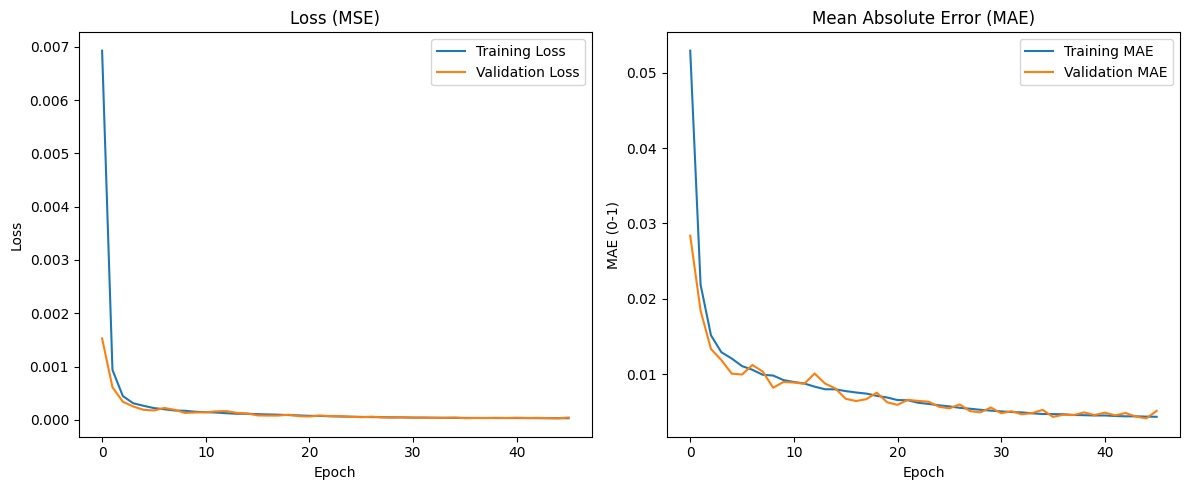

In [20]:
# =============================================================================
# CELL 6: HUẤN LUYỆN VÀ ĐÁNH GIÁ (MAIN) - ĐÃ CÓ CALLBACKS
# =============================================================================

# --- 1. CÁC HẰNG SỐ HUẤN LUYỆN ---
N_SAMPLES = 50000 # Số lượng mẫu dữ liệu
TEST_SIZE = 0.2 
RANDOM_STATE = 42
EPOCHS = 1000 # <-- TĂNG SỐ EPOCHS LÊN (EarlyStopping sẽ tự dừng)
BATCH_SIZE = 32
MODEL_PATH_2 = 'v2_16x16_fused.keras' # <-- ĐƯA LÊN ĐÂY

# --- BƯỚC 1: TẠO DỮ LIỆU ---
(X_map_data, X_force_data), y_angle_data = tao_bo_du_lieu_hop_nhat(
    n_samples=N_SAMPLES, 
    k_thuoc=K_THUOC
)

print("\n--- Kích thước dữ liệu ---")
print(f"X_map_data:   {X_map_data.shape}")
print(f"X_force_data: {X_force_data.shape}")
print(f"y_angle_data: {y_angle_data.shape}")

# --- BƯỚC 2: CHIA DỮ LIỆU TRAIN/VALIDATION ---
print("\nĐang chia dữ liệu Train/Validation...")
X_map_train, X_map_val, X_force_train, X_force_val, y_angle_train, y_angle_val = train_test_split(
    X_map_data, X_force_data, y_angle_data, 
    test_size=TEST_SIZE, 
    random_state=RANDOM_STATE
)
print(f"Số mẫu Train: {len(y_angle_train)}")
print(f"Số mẫu Val:   {len(y_angle_val)}")

# --- BƯỚC 3: XÂY DỰNG MÔ HÌNH ---
print("\nĐang xây dựng mô hình...")
model_2_0 = xay_dung_model_hop_nhat(k_thuoc=K_THUOC)
print("\n--- Cấu trúc Mô hình Hợp nhất (Model 2.0) ---")
model_2_0.summary()

# --- BƯỚC 4: BIÊN DỊCH MÔ HÌNH ---
print("\nĐang biên dịch mô hình...")
model_2_0.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=['mean_absolute_error'] # MAE
)

# =============================================================
# === BƯỚC 4A: ĐỊNH NGHĨA CALLBACKS (PHẦN MỚI THÊM) ===
# =============================================================

# 1. EarlyStopping: Dừng sớm nếu val_loss không cải thiện sau 10 epochs
#    restore_best_weights=True: Rất quan trọng, nó sẽ trả lại trọng số
#    của epoch tốt nhất khi kết thúc huấn luyện.
early_stopping_cb = EarlyStopping(
    monitor='val_loss', 
    patience=10, 
    verbose=1, 
    restore_best_weights=True,
    min_delta=1e-5  # <-- THÊM DÒNG NÀY
)

# 2. ModelCheckpoint: Chỉ lưu lại model (file .keras) tốt nhất
model_checkpoint_cb = ModelCheckpoint(
    filepath=MODEL_PATH_2, 
    save_best_only=True, # Chỉ lưu khi 'monitor' cải thiện
    monitor='val_loss', 
    verbose=1
)

# =============================================================
# === BƯỚC 5: HUẤN LUYỆN VỚI CALLBACKS ===
# =============================================================
print("\n--- Bắt đầu Huấn luyện (với EarlyStopping & ModelCheckpoint) ---")
history = model_2_0.fit(
    x=[X_map_train, X_force_train],  
    y=y_angle_train,
    validation_data=(
        [X_map_val, X_force_val], 
        y_angle_val
    ),
    epochs=EPOCHS, # Đặt số epochs lớn, nó sẽ tự dừng
    batch_size=BATCH_SIZE,
    verbose=1,
    callbacks=[early_stopping_cb, model_checkpoint_cb] # <-- THÊM CALLBACKS VÀO ĐÂY
)

# --- BƯỚC 6: ĐÁNH GIÁ ---
# (Không cần model_2_0.save() nữa vì ModelCheckpoint đã làm)
print(f"\nĐã lưu mô hình TỐT NHẤT tại '{MODEL_PATH_2}' (nhờ ModelCheckpoint).")
print("Model trong bộ nhớ cũng đã được khôi phục về trọng số tốt nhất (nhờ EarlyStopping).")

print("\n--- Đánh giá trên tập Validation (với model tốt nhất) ---")
val_loss, val_mae = model_2_0.evaluate([X_map_val, X_force_val], y_angle_val)
print(f"Validation Loss (MSE): {val_loss:.6f}")
print(f"Validation MAE (0-1): {val_mae:.6f}")
print(f"==> Sai số trung bình dự đoán (Validation): {val_mae * 90.0:.2f} độ")

# --- BƯỚC 7: VẼ BIỂU ĐỒ ---
print("\nĐang vẽ biểu đồ huấn luyện...")
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss (MSE)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mean_absolute_error'], label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.title('Mean Absolute Error (MAE)')
plt.xlabel('Epoch')
plt.ylabel('MAE (0-1)')
plt.legend()

plt.tight_layout()
plt.show()

In [7]:
# =============================================================================
# PHẦN 5: KIỂM TRA HIỆU SUẤT MÔ HÌNH ĐÃ HUẤN LUYỆN (16x16)
# =============================================================================
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time # Để đo thời gian tạo dataset nếu chạy lại

# Đảm bảo các hàm giả lập đã được định nghĩa hoặc import
# Nếu bạn chạy từ đầu file Jupyter, chúng đã có sẵn.
# Nếu chạy riêng, cần import từ file giả lập:
# from your_simulation_file import gia_lap_ban_do_tinh_v7, gia_lap_ban_do_dong, tao_dom_gaussian, tao_dom_gaussian_khong_wrap

print("--- Bắt đầu kiểm tra hiệu suất mô hình ---")

# --- 1. Tải lại mô hình tốt nhất ---
# Đảm bảo tên file trùng với tên bạn đã dùng trong ModelCheckpoint
MODEL_PATH_1 = 'v1_16x16.keras' 
try:
    loaded_model_1 = tf.keras.models.load_model(MODEL_PATH_1)
    print(f"Đã tải thành công mô hình từ '{MODEL_PATH_1}'.")
except Exception as e:
    print(f"Lỗi khi tải mô hình: {e}")
    print("Vui lòng đảm bảo rằng bạn đã chạy huấn luyện và mô hình đã được lưu.")
    loaded_model_1 = None

if loaded_model_1:
    # --- 2. Tạo lại dữ liệu (hoặc sử dụng X_tinh, Y_tinh đã có) ---
    # Nếu bạn chạy cell này độc lập, bạn sẽ cần tạo lại dataset
    # Nếu bạn chạy ngay sau cell huấn luyện, X_tinh và Y_tinh đã có sẵn
    if 'X_tinh' not in locals() or 'Y_tinh' not in locals() or X_tinh.shape[0] != SO_LUONG_MAU:
        print("\nĐang tạo lại bộ dữ liệu để đánh giá...")
        start_time_data = time.time()
        
        SO_LUONG_MAU = 50000 # Hoặc số lượng mẫu bạn đã dùng
        K_THUOC = 16 # Hoặc kích thước ma trận bạn đã dùng
        
        X_tinh_full = np.zeros((SO_LUONG_MAU, K_THUOC, K_THUOC, 1))
        Y_tinh_full = np.zeros((SO_LUONG_MAU, 3)) 

        for i in range(SO_LUONG_MAU):
            goc_MCP_ngau_nhien = np.random.uniform(0, 90)
            goc_PIP_ngau_nhien = np.random.uniform(0, 90)
            goc_DIP_ngau_nhien = np.random.uniform(0, 90)
            
            ban_do_tinh, goc_MCP_thuc, goc_PIP_thuc, goc_DIP_hieu_luc_thuc = gia_lap_ban_do_tinh_v7(goc_MCP_ngau_nhien, goc_PIP_ngau_nhien, goc_DIP_ngau_nhien, k_thuoc=K_THUOC)

            X_tinh_full[i] = ban_do_tinh.reshape(K_THUOC, K_THUOC, 1)
            Y_tinh_full[i] = [goc_MCP_thuc / 90.0,
                              goc_PIP_thuc / 90.0,
                              goc_DIP_hieu_luc_thuc / 90.0]
        
        # Chia lại thành tập train và validation để đảm bảo tính nhất quán
        _, X_val, _, Y_val = train_test_split(X_tinh_full, Y_tinh_full, test_size=0.2, random_state=42)
        print(f"Đã tạo lại và chia dữ liệu trong {time.time() - start_time_data:.2f} giây.")
    else:
        # Nếu X_tinh và Y_tinh đã có từ quá trình huấn luyện, chỉ cần lấy tập validation
        print("\nSử dụng dữ liệu đã có từ quá trình huấn luyện.")
        # Lấy tập validation từ lịch sử huấn luyện
        # Lưu ý: nếu bạn không tách tập test riêng, đây sẽ là tập validation
        # Nếu đã chia train_test_split thủ công, X_val, Y_val đã có.
        # Nếu không, cần phải chia lại một lần nữa
        _, X_val, _, Y_val = train_test_split(X_tinh, Y_tinh, test_size=0.2, random_state=42)
        
    # --- 3. Đánh giá mô hình trên tập validation ---
    print(f"\nĐánh giá Model 1 trên {len(X_val)} mẫu validation:")
    loss, mae = loaded_model_1.evaluate(X_val, Y_val, verbose=1)
    
    mae_degrees = mae * 90
    print(f"Loss trên tập validation: {loss:.4f}")
    print(f"MAE trên tập validation (chuẩn hóa): {mae:.4f}")
    print(f"MAE trên tập validation (độ): {mae_degrees:.2f} độ")
    
    print("\n--- Kết thúc kiểm tra hiệu suất cơ bản ---")
else:
    print("Không thể tiến hành đánh giá vì mô hình chưa được tải.")

--- Bắt đầu kiểm tra hiệu suất mô hình ---
Đã tải thành công mô hình từ 'v1_16x16.keras'.

Sử dụng dữ liệu đã có từ quá trình huấn luyện.

Đánh giá Model 1 trên 10000 mẫu validation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0021 - mae: 0.0350
Loss trên tập validation: 0.0021
MAE trên tập validation (chuẩn hóa): 0.0350
MAE trên tập validation (độ): 3.15 độ

--- Kết thúc kiểm tra hiệu suất cơ bản ---


Đã tải thành công mô hình từ 'v1_16x16.keras'.

--- Bắt đầu kiểm tra ngẫu nhiên Model 1 (10 mẫu) ---

--- Mẫu kiểm tra 1/10 ---


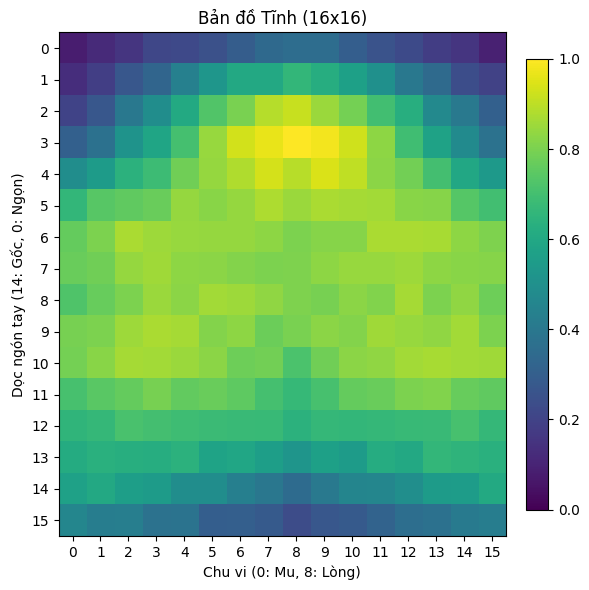


--- Mẫu kiểm tra 2/10 ---


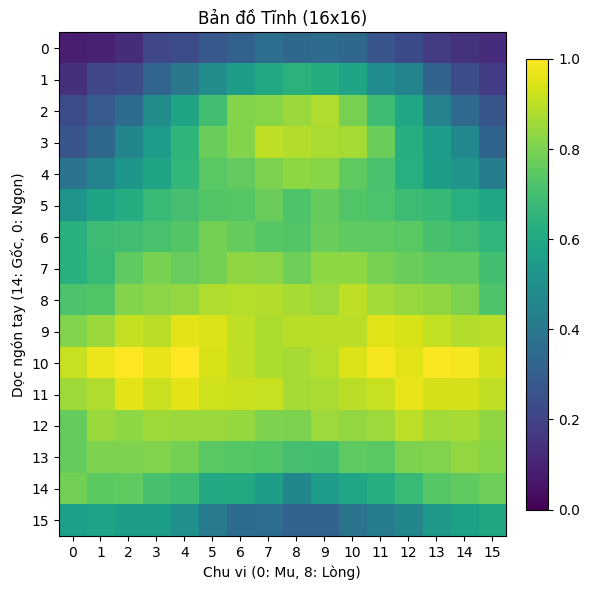


--- Mẫu kiểm tra 3/10 ---


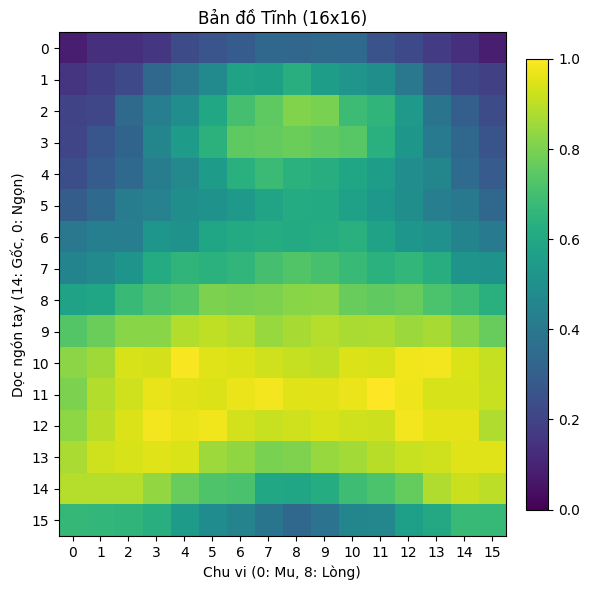


--- Mẫu kiểm tra 4/10 ---


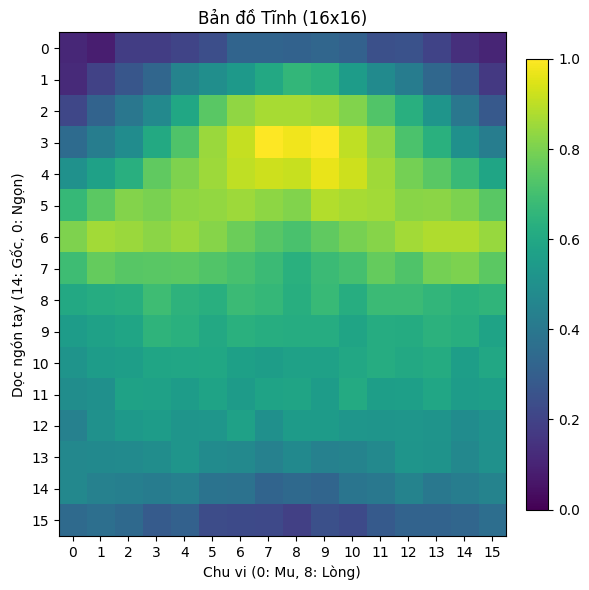


--- Mẫu kiểm tra 5/10 ---


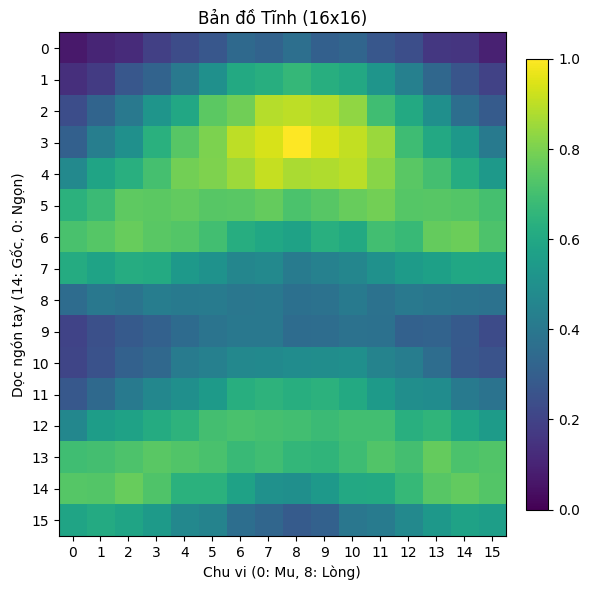


--- Mẫu kiểm tra 6/10 ---


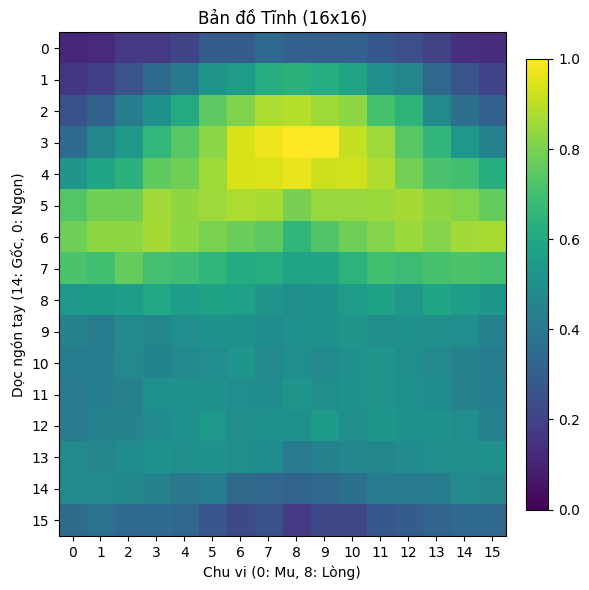


--- Mẫu kiểm tra 7/10 ---


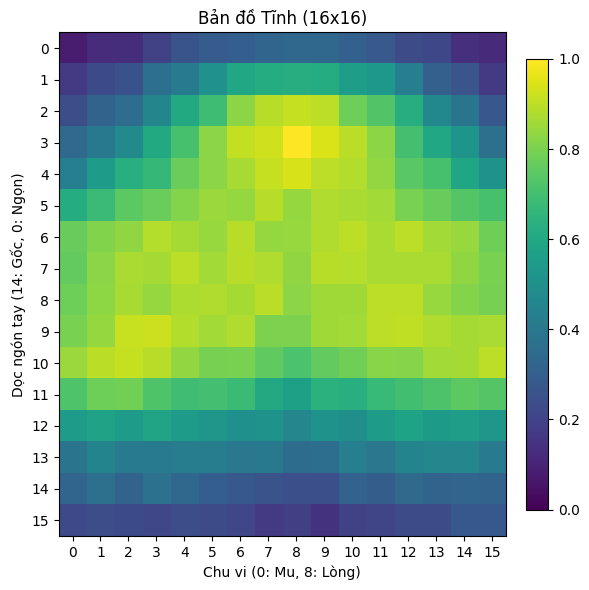


--- Mẫu kiểm tra 8/10 ---


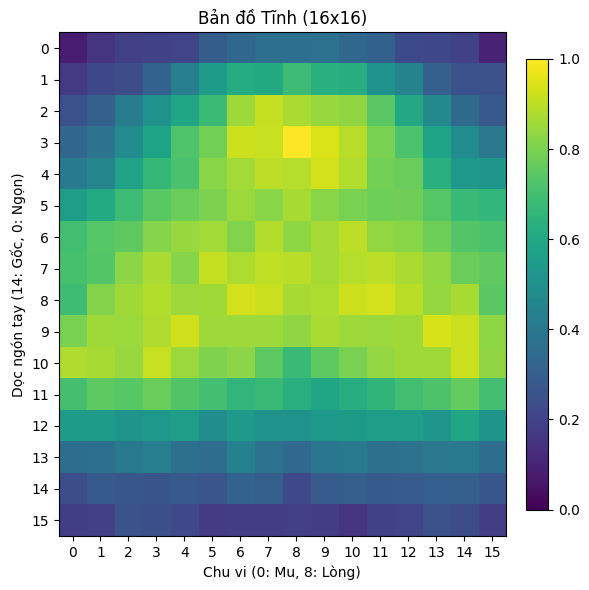


--- Mẫu kiểm tra 9/10 ---


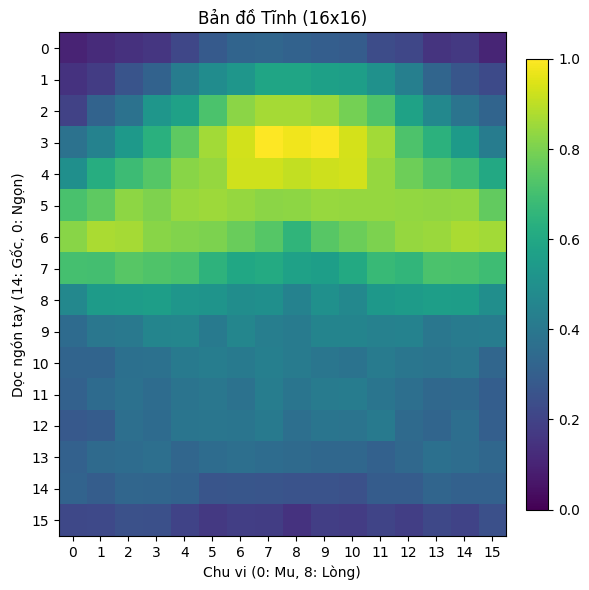


--- Mẫu kiểm tra 10/10 ---


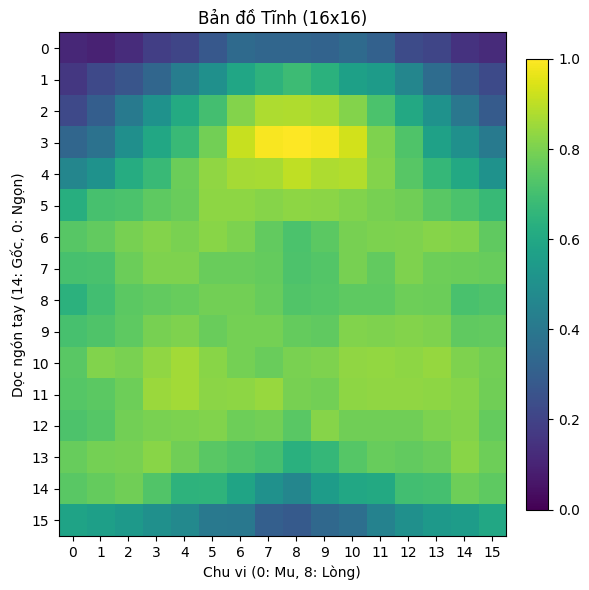

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, HTML # Để hiển thị kết quả đẹp hơn

# Đảm bảo các hàm giả lập đã được định nghĩa ở các ô trước đó
# Hoặc nếu bạn đã tách ra file .py, hãy import chúng:
# from your_simulation_file import gia_lap_ban_do_tinh_v7, gia_lap_ban_do_dong

# --- 1. Tải lại mô hình tốt nhất (nếu chưa tải) ---
# Đảm bảo tên file trùng với tên bạn đã dùng trong ModelCheckpoint
MODEL_PATH_1 = 'v1_16x16.keras' 
try:
    loaded_model_1 = tf.keras.models.load_model(MODEL_PATH_1)
    print(f"Đã tải thành công mô hình từ '{MODEL_PATH_1}'.")
except Exception as e:
    print(f"Lỗi khi tải mô hình: {e}")
    print("Vui lòng đảm bảo rằng bạn đã chạy huấn luyện và mô hình đã được lưu.")
    loaded_model_1 = None

if loaded_model_1:
    K_THUOC = 16 # Kích thước ma trận bạn đã dùng để huấn luyện

    def kiem_tra_ngau_nhien_model_1(num_tests=5):
        print(f"\n--- Bắt đầu kiểm tra ngẫu nhiên Model 1 ({num_tests} mẫu) ---")
        
        for i in range(num_tests):
            print(f"\n--- Mẫu kiểm tra {i+1}/{num_tests} ---")
            
            # 1. Tạo các góc ngẫu nhiên
            goc_MCP_thuc = np.random.uniform(0, 90)
            goc_PIP_thuc = np.random.uniform(0, 90)
            goc_DIP_ngau_nhien = np.random.uniform(0, 90) # Dữ liệu đầu vào
            
            # 2. Giả lập bản đồ áp suất và lấy các góc hiệu lực thực tế
            # (gia_lap_ban_do_tinh_v7 trả về ban_do, goc_MCP_thuc, goc_PIP_thuc, goc_DIP_hieu_luc_thuc)
            ban_do_tinh, _, _, goc_DIP_hieu_luc_thuc_tu_sim = \
                gia_lap_ban_do_tinh_v7(goc_MCP_thuc, goc_PIP_thuc, goc_DIP_ngau_nhien, k_thuoc=K_THUOC)
            
            # Chuẩn hóa các góc thực tế về 0-1 (đầu ra mong muốn của model)
            y_thuc_chuan_hoa = np.array([goc_MCP_thuc / 90.0,
                                          goc_PIP_thuc / 90.0,
                                          goc_DIP_hieu_luc_thuc_tu_sim / 90.0])

            # 3. Chuẩn bị đầu vào cho model
            # Reshape thành (1, K_THUOC, K_THUOC, 1) vì model mong đợi batch input
            input_map = ban_do_tinh.reshape(1, K_THUOC, K_THUOC, 1)

            # 4. Sử dụng model để dự đoán
            y_du_doan_chuan_hoa = loaded_model_1.predict(input_map, verbose=0)[0] # Lấy kết quả đầu tiên từ batch

            # 5. Chuyển đổi dự đoán về độ
            goc_MCP_du_doan = y_du_doan_chuan_hoa[0] * 90.0
            goc_PIP_du_doan = y_du_doan_chuan_hoa[1] * 90.0
            goc_DIP_du_doan = y_du_doan_chuan_hoa[2] * 90.0
            
            # 6. Tính toán sai số
            sai_so_MCP = np.abs(goc_MCP_du_doan - goc_MCP_thuc)
            sai_so_PIP = np.abs(goc_PIP_du_doan - goc_PIP_thuc)
            sai_so_DIP = np.abs(goc_DIP_du_doan - goc_DIP_hieu_luc_thuc_tu_sim)
            
            mae_mau = (sai_so_MCP + sai_so_PIP + sai_so_DIP) / 3

            # 7. Hiển thị kết quả
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            im = ax.imshow(ban_do_tinh, cmap='viridis', vmin=0, vmax=1, aspect='auto')
            ax.set_title(f"Bản đồ Tĩnh ({K_THUOC}x{K_THUOC})")
            ax.set_xlabel(f"Chu vi (0: Mu, {4*(K_THUOC/8.0):.0f}: Lòng)")
            ax.set_ylabel(f"Dọc ngón tay ({7*(K_THUOC/8.0):.0f}: Gốc, 0: Ngọn)")
            ax.set_xticks(np.arange(K_THUOC))
            ax.set_yticks(np.arange(K_THUOC))
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            plt.tight_layout()
            plt.show()

            display(HTML(f"""
            <b>Góc thực tế (độ):</b><br>
            &nbsp;&nbsp;&nbsp;&nbsp;MCP: {goc_MCP_thuc:.2f}<br>
            &nbsp;&nbsp;&nbsp;&nbsp;PIP: {goc_PIP_thuc:.2f}<br>
            &nbsp;&nbsp;&nbsp;&nbsp;DIP (hiệu lực): {goc_DIP_hieu_luc_thuc_tu_sim:.2f}<br>
            <b>Góc dự đoán (độ):</b><br>
            &nbsp;&nbsp;&nbsp;&nbsp;MCP: {goc_MCP_du_doan:.2f} (Sai số: {sai_so_MCP:.2f})<br>
            &nbsp;&nbsp;&nbsp;&nbsp;PIP: {goc_PIP_du_doan:.2f} (Sai số: {sai_so_PIP:.2f})<br>
            &nbsp;&nbsp;&nbsp;&nbsp;DIP (hiệu lực): {goc_DIP_du_doan:.2f} (Sai số: {sai_so_DIP:.2f})<br>
            <b>Sai số trung bình tuyệt đối (MAE) cho mẫu này: {mae_mau:.2f} độ</b>
            <hr>
            """))

    # Gọi hàm để chạy kiểm tra
    kiem_tra_ngau_nhien_model_1(num_tests=10) # Bạn có thể thay đổi số lượng mẫu kiểm tra tại đây

else:
    print("Không thể chạy kiểm tra ngẫu nhiên vì mô hình chưa được tải thành công.")

In [9]:
# =============================================================================
# Ô CODE 6: XÂY DỰNG MODEL 2 (Đoán Độ Cứng 16x16)
# =============================================================================

print("\n--- Bắt đầu Xây dựng Model 2 (Đoán Độ Cứng 16x16) ---")

model_2 = Sequential([
    # Input là ảnh 16x16x1
    Conv2D(32, (3, 3), activation='relu', input_shape=(K_THUOC, K_THUOC, 1), padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 16x16 -> 8x8
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 8x8 -> 4x4
    
    # Một cặp Conv/Pool nữa, giống Model 1
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)), # 4x4 -> 2x2
    
    Flatten(), # "Duỗi" ảnh 2x2x128
    
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    
    Dense(1, activation='linear') # Output 1 giá trị (độ cứng), dùng 'linear' vì giá trị không giới hạn 0-1
])

# Optimizer và compile cho Model 2
optimizer_2 = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_2.compile(optimizer=optimizer_2, loss='mean_squared_error', metrics=['mae'])
model_2.summary()

print("--- Kết thúc Xây dựng Model 2 ---")


--- Bắt đầu Xây dựng Model 2 (Đoán Độ Cứng 16x16) ---


d:\Simulation_ViSEF\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 16, 16, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167,553 (654.50 KB)

 Trainable params: 167,105 (652.75 KB)

 Non-trainable params: 448 (1.75 KB)

--- Kết thúc Xây dựng Model 2 ---


In [10]:
# =============================================================================
# Ô CODE 7: HUẤN LUYỆN MODEL 2 (Đoán Độ Cứng 16x16)
# =============================================================================

# Tăng patience cho EarlyStopping (nếu cần)
early_stopping_2 = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True, verbose=1) 
# Đổi tên file checkpoint cho Model 2
checkpoint_2 = ModelCheckpoint('v2_16x16_do_cung.keras', save_best_only=True, monitor='val_loss', verbose=1)

print("\nHuấn luyện Model 2 (Đoán Độ Cứng 16x16)...")
history_2 = model_2.fit(
    X_dong, Y_dong, # Sử dụng dữ liệu X_dong và Y_dong
    epochs=1000, # Đặt số epoch đủ cao
    batch_size=64,
    validation_split=0.2,
    callbacks=[early_stopping_2, checkpoint_2]
)
print("Đã lưu Model 2 (tốt nhất) vào 'v2_16x16_do_cung.keras'.")
print("--- Kết thúc Huấn luyện Model 2 ---")


Huấn luyện Model 2 (Đoán Độ Cứng 16x16)...
Epoch 1/1000
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 2.6050 - mae: 1.0372
Epoch 1: val_loss improved from None to 5.23470, saving model to v2_16x16_do_cung.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 14s 18ms/step - loss: 1.0824 - mae: 0.7195 - val_loss: 5.2347 - val_mae: 1.9589
Epoch 2/1000
625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.4597 - mae: 0.5085
Epoch 2: val_loss improved from 5.23470 to 0.88294, saving model to v2_16x16_do_cung.keras
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.4279 - mae: 0.4876 - val_loss: 0.8829 - val_mae: 0.8117
Epoch 3/1000
622/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.3375 - mae: 0.4307
Epoch 3: val_loss did not improve from 0.88294
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.3258 - mae: 0.4228 - val_loss: 1.3065 - val_mae: 1.0016
Epoch 4/1000
623/625 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.2940 - mae: 0.3993
Epoch 4: val_loss did not improve from 0.88294
625/625 ━━━━━━━━━━━━


--- Bắt đầu kiểm tra hiệu suất Model 2 ---
Đã tải thành công mô hình từ 'v2_16x16_do_cung.keras'.

Sử dụng dữ liệu động đã có từ quá trình huấn luyện.

Đánh giá Model 2 trên 10000 mẫu validation:
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.8823 - mae: 0.8106
Loss trên tập validation (Model 2): 0.8823
MAE trên tập validation (Model 2): 0.81 đơn vị độ cứng

--- Bắt đầu kiểm tra ngẫu nhiên Model 2 ---

--- Mẫu kiểm tra 1/5 ---


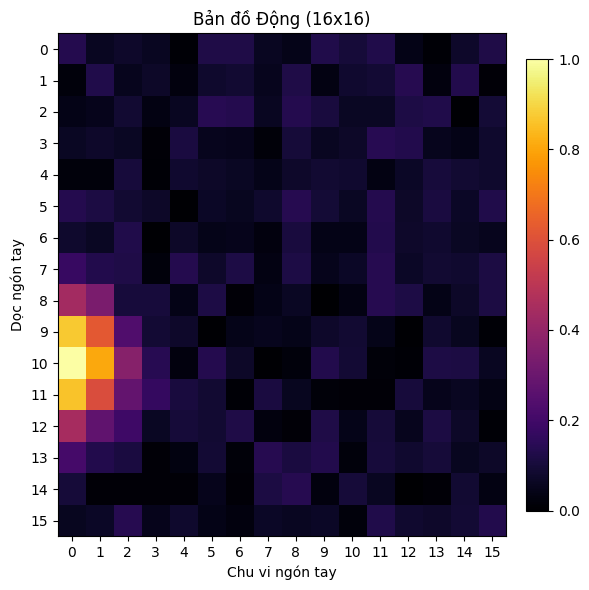


--- Mẫu kiểm tra 2/5 ---


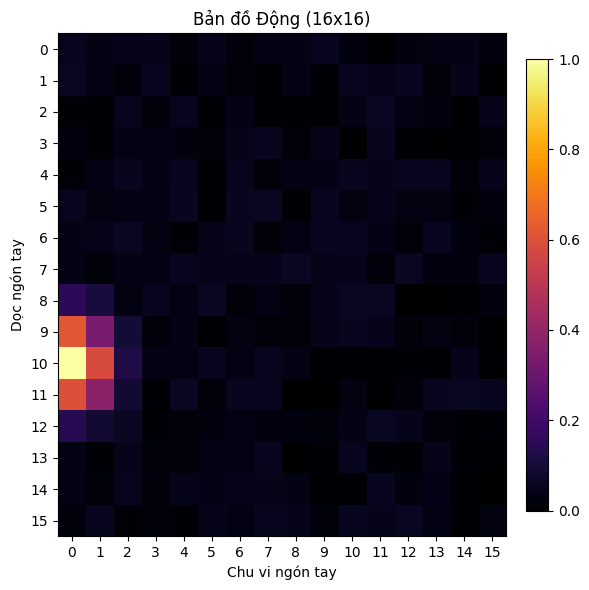


--- Mẫu kiểm tra 3/5 ---


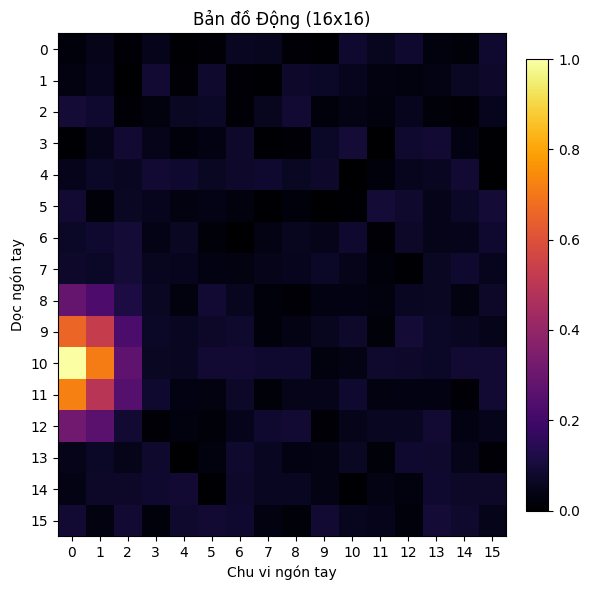


--- Mẫu kiểm tra 4/5 ---


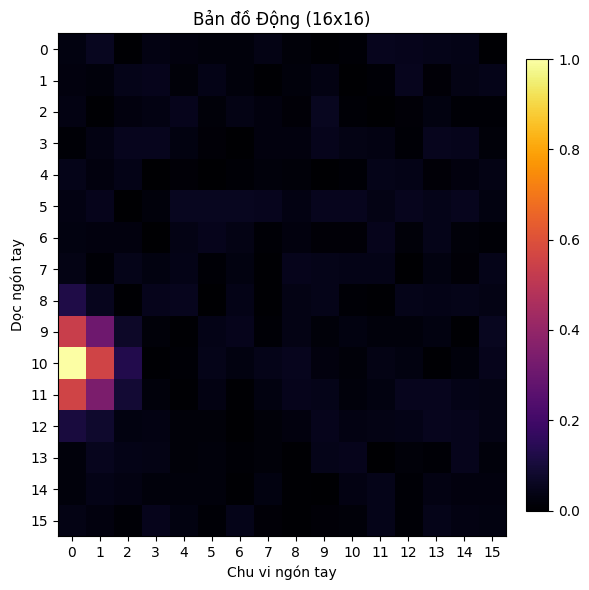


--- Mẫu kiểm tra 5/5 ---


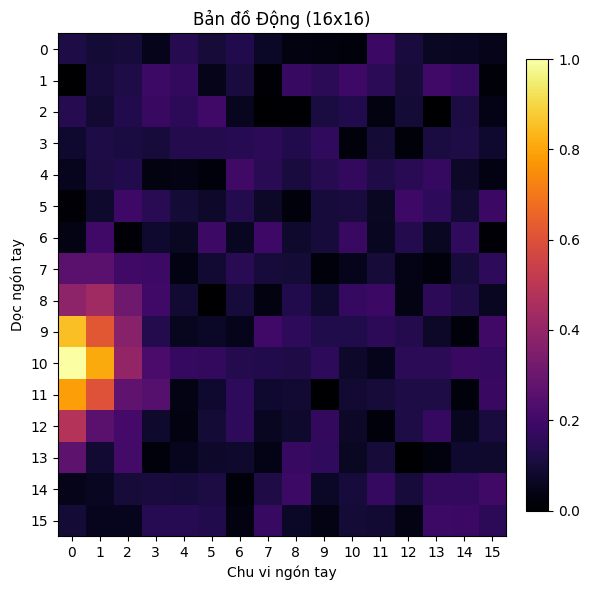

In [12]:
# =============================================================================
# Ô CODE 8: ĐÁNH GIÁ VÀ KIỂM TRA NGẪU NHIÊN MODEL 2
# =============================================================================

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from IPython.display import display, HTML

print("\n--- Bắt đầu kiểm tra hiệu suất Model 2 ---")

# --- 1. Tải lại mô hình tốt nhất ---
MODEL_PATH_2 = 'v2_16x16_do_cung.keras' 
try:
    loaded_model_2 = tf.keras.models.load_model(MODEL_PATH_2)
    print(f"Đã tải thành công mô hình từ '{MODEL_PATH_2}'.")
except Exception as e:
    print(f"Lỗi khi tải mô hình: {e}")
    print("Vui lòng đảm bảo rằng bạn đã chạy huấn luyện Model 2 và mô hình đã được lưu.")
    loaded_model_2 = None

if loaded_model_2:
    K_THUOC = 16 # Kích thước ma trận bạn đã dùng để huấn luyện
    VI_TRI_THAM_DO_MAC_DINH_DONG = (5.0 * (K_THUOC / 8.0), 0) # Vị trí thăm dò bạn đã dùng khi tạo dữ liệu
    
    # --- 2. Chuẩn bị dữ liệu validation cho Model 2 ---
    # Nếu X_dong và Y_dong đã có từ quá trình huấn luyện, chỉ cần lấy tập validation
    if 'X_dong' not in locals() or 'Y_dong' not in locals() or X_dong.shape[0] != SO_LUONG_MAU:
        # Trường hợp bạn chạy ô này độc lập mà chưa có X_dong, Y_dong
        print("\nĐang tạo lại bộ dữ liệu động để đánh giá...")
        X_dong_full = np.zeros((SO_LUONG_MAU, K_THUOC, K_THUOC, 1))
        Y_dong_full = np.zeros((SO_LUONG_MAU, 1))
        
        for i in range(SO_LUONG_MAU):
            do_cung_ngau_nhien = np.random.uniform(0, 10)
            ban_do_dong = gia_lap_ban_do_dong(VI_TRI_THAM_DO_MAC_DINH_DONG, do_cung_ngau_nhien, k_thuoc=K_THUOC)
            X_dong_full[i] = ban_do_dong.reshape(K_THUOC, K_THUOC, 1)
            Y_dong_full[i] = [do_cung_ngau_nhien]
        
        _, X_val_dong, _, Y_val_dong = train_test_split(X_dong_full, Y_dong_full, test_size=0.2, random_state=42)
        print(f"Đã tạo lại và chia dữ liệu động.")
    else:
        print("\nSử dụng dữ liệu động đã có từ quá trình huấn luyện.")
        _, X_val_dong, _, Y_val_dong = train_test_split(X_dong, Y_dong, test_size=0.2, random_state=42)
        
    # --- 3. Đánh giá mô hình trên tập validation ---
    print(f"\nĐánh giá Model 2 trên {len(X_val_dong)} mẫu validation:")
    loss_2, mae_2 = loaded_model_2.evaluate(X_val_dong, Y_val_dong, verbose=1)
    
    print(f"Loss trên tập validation (Model 2): {loss_2:.4f}")
    print(f"MAE trên tập validation (Model 2): {mae_2:.2f} đơn vị độ cứng")
    
    print("\n--- Bắt đầu kiểm tra ngẫu nhiên Model 2 ---")

    def kiem_tra_ngau_nhien_model_2(num_tests=5):
        for i in range(num_tests):
            print(f"\n--- Mẫu kiểm tra {i+1}/{num_tests} ---")
            
            # 1. Tạo độ cứng ngẫu nhiên
            do_cung_thuc = np.random.uniform(0, 10)
            
            # 2. Giả lập bản đồ áp suất động
            ban_do_dong = gia_lap_ban_do_dong(VI_TRI_THAM_DO_MAC_DINH_DONG, do_cung_thuc, k_thuoc=K_THUOC)
            
            # 3. Chuẩn bị đầu vào cho model
            input_map_dong = ban_do_dong.reshape(1, K_THUOC, K_THUOC, 1)

            # 4. Sử dụng model để dự đoán độ cứng
            do_cung_du_doan = loaded_model_2.predict(input_map_dong, verbose=0)[0][0] # Lấy giá trị duy nhất

            # 5. Tính toán sai số
            sai_so_do_cung = np.abs(do_cung_du_doan - do_cung_thuc)
            
            # 6. Hiển thị kết quả
            fig, ax = plt.subplots(1, 1, figsize=(6, 6))
            im = ax.imshow(ban_do_dong, cmap='inferno', vmin=0, vmax=1, aspect='auto')
            ax.set_title(f"Bản đồ Động ({K_THUOC}x{K_THUOC})")
            ax.set_xlabel("Chu vi ngón tay")
            ax.set_ylabel("Dọc ngón tay")
            ax.set_xticks(np.arange(K_THUOC))
            ax.set_yticks(np.arange(K_THUOC))
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
            plt.tight_layout()
            plt.show()

            display(HTML(f"""
            <b>Độ cứng thực tế:</b> {do_cung_thuc:.2f}<br>
            <b>Độ cứng dự đoán:</b> {do_cung_du_doan:.2f}<br>
            <b>Sai số tuyệt đối:</b> {sai_so_do_cung:.2f}<br>
            <hr>
            """))

    # Gọi hàm để chạy kiểm tra ngẫu nhiên
    kiem_tra_ngau_nhien_model_2(num_tests=5) # Thay đổi số lượng mẫu kiểm tra tại đây

else:
    print("Không thể chạy kiểm tra hiệu suất Model 2 vì mô hình chưa được tải.")

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import display, HTML # Để hiển thị kết quả đẹp hơn

# Đảm bảo các hàm giả lập đã được định nghĩa ở các ô trước đó
# Hoặc nếu bạn đã tách ra file .py, hãy import chúng:
# from your_simulation_file import gia_lap_ban_do_tinh_v7, gia_lap_ban_do_dong

# --- 1. Tải lại mô hình tốt nhất (nếu chưa tải) ---
MODEL_PATH_1 = 'v1_16x16.keras' 
try:
    loaded_model_1 = tf.keras.models.load_model(MODEL_PATH_1)
    print(f"Đã tải thành công mô hình từ '{MODEL_PATH_1}'.")
except Exception as e:
    print(f"Lỗi khi tải mô hình: {e}")
    print("Vui lòng đảm bảo rằng bạn đã chạy huấn luyện và mô hình đã được lưu.")
    loaded_model_1 = None

if loaded_model_1:
    K_THUOC = 16 # Kích thước ma trận bạn đã dùng để huấn luyện

    # Đổi tên hàm để phản ánh đúng chức năng
    def kiem_tra_lap_lai_model_1(num_predictions=10):
        print(f"\n--- Bắt đầu kiểm tra lặp lại Model 1 ({num_predictions} lần trên CÙNG MỘT mẫu) ---")
        
        # 1. TẠO DATA MỘT LẦN DUY NHẤT (BÊN NGOÀI VÒNG LẶP)
        print("Đang tạo 1 mẫu dữ liệu ngẫu nhiên duy nhất...")
        goc_MCP_thuc = np.random.uniform(0, 90)
        goc_PIP_thuc = np.random.uniform(0, 90)
        goc_DIP_ngau_nhien = np.random.uniform(0, 90) # Dữ liệu đầu vào
        
        # 2. Giả lập bản đồ áp suất và lấy các góc hiệu lực thực tế
        ban_do_tinh, _, _, goc_DIP_hieu_luc_thuc_tu_sim = \
            gia_lap_ban_do_tinh_v7(goc_MCP_thuc, goc_PIP_thuc, goc_DIP_ngau_nhien, k_thuoc=K_THUOC)
        
        # Chuẩn hóa các góc thực tế về 0-1 (đầu ra mong muốn của model)
        y_thuc_chuan_hoa = np.array([goc_MCP_thuc / 90.0,
                                     goc_PIP_thuc / 90.0,
                                     goc_DIP_hieu_luc_thuc_tu_sim / 90.0])

        # 3. CHUẨN BỊ INPUT CHO MODEL (MỘT LẦN)
        # Reshape thành (1, K_THUOC, K_THUOC, 1) vì model mong đợi batch input
        input_map = ban_do_tinh.reshape(1, K_THUOC, K_THUOC, 1)

        # 4. HIỂN THỊ BẢN ĐỒ VÀ GIÁ TRỊ THỰC (MỘT LẦN)
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
        im = ax.imshow(ban_do_tinh, cmap='viridis', vmin=0, vmax=1, aspect='auto')
        ax.set_title(f"Bản đồ Tĩnh ({K_THUOC}x{K_THUOC}) - Dùng cho {num_predictions} lần dự đoán")
        ax.set_xlabel(f"Chu vi (0: Mu, {4*(K_THUOC/8.0):.0f}: Lòng)")
        ax.set_ylabel(f"Dọc ngón tay ({7*(K_THUOC/8.0):.0f}: Gốc, 0: Ngọn)")
        ax.set_xticks(np.arange(K_THUOC))
        ax.set_yticks(np.arange(K_THUOC))
        fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        plt.tight_layout()
        plt.show()

        display(HTML(f"""
        <h3>Thông tin mẫu dữ liệu cố định:</h3>
        <b>Góc thực tế (độ):</b><br>
        &nbsp;&nbsp;&nbsp;&nbsp;MCP: {goc_MCP_thuc:.2f}<br>
        &nbsp;&nbsp;&nbsp;&nbsp;PIP: {goc_PIP_thuc:.2f}<br>
        &nbsp;&nbsp;&nbsp;&nbsp;DIP (hiệu lực): {goc_DIP_hieu_luc_thuc_tu_sim:.2f}<br>
        <hr>
        """))
        
        print(f"--- Bắt đầu chạy {num_predictions} lần dự đoán trên mẫu này ---")
        
        # 5. CHẠY DỰ ĐOÁN LẶP LẠI (TRONG VÒNG LẶP)
        for i in range(num_predictions):
            # 6. Sử dụng model để dự đoán (trên CÙNG input_map)
            y_du_doan_chuan_hoa = loaded_model_1.predict(input_map, verbose=0)[0] # Lấy kết quả đầu tiên từ batch

            # 7. Chuyển đổi dự đoán về độ
            goc_MCP_du_doan = y_du_doan_chuan_hoa[0] * 90.0
            goc_PIP_du_doan = y_du_doan_chuan_hoa[1] * 90.0
            goc_DIP_du_doan = y_du_doan_chuan_hoa[2] * 90.0
            
            # 8. Tính toán sai số
            sai_so_MCP = np.abs(goc_MCP_du_doan - goc_MCP_thuc)
            sai_so_PIP = np.abs(goc_PIP_du_doan - goc_PIP_thuc)
            sai_so_DIP = np.abs(goc_DIP_du_doan - goc_DIP_hieu_luc_thuc_tu_sim)
            
            mae_mau = (sai_so_MCP + sai_so_PIP + sai_so_DIP) / 3

            # 9. Hiển thị kết quả của lần dự đoán này
            display(HTML(f"""
            <b>Lần dự đoán {i+1}/{num_predictions}:</b><br>
            &nbsp;&nbsp;&nbsp;&nbsp;MCP: {goc_MCP_du_doan:.2f} (Sai số: {sai_so_MCP:.2f})<br>
            &nbsp;&nbsp;&nbsp;&nbsp;PIP: {goc_PIP_du_doan:.2f} (Sai số: {sai_so_PIP:.2f})<br>
            &nbsp;&nbsp;&nbsp;&nbsp;DIP (hiệu lực): {goc_DIP_du_doan:.2f} (Sai số: {sai_so_DIP:.2f})<br>
            <b>&nbsp;&nbsp;&nbsp;&nbsp;MAE lần này: {mae_mau:.2f} độ</b>
            <hr>
            """))

    # Gọi hàm để chạy kiểm tra
    kiem_tra_lap_lai_model_1(num_predictions=10) # Chạy 10 lần dự đoán trên 1 mẫu

else:
    print("Không thể chạy kiểm tra lặp lại vì mô hình chưa được tải thành công.")